# Projet 1: Wind turbine control: MDP part

In [97]:
import numpy as np
from IPython.display import display, Math, Latex
from IPython import display
import matplotlib.pyplot as plt

In [98]:
# First part: MDP and optimal control

1. Assume that $V$ is constant in time and equal to $V_{max}$ , and that moving left or right costs $a$ unit of energy. Model the problem as a MDP, and explain how to compute the optimal solution for a given discount factor $\gamma$.

1.1 Model the problem as a MDP

States $S$: We use $\theta_t$ represent orientation of turbine $\theta_t$ and $\theta_w$ the orientation of wind. $\theta = \theta_t - \theta_w$ is the difference of angle between the turbine orientation and the turbine orientation. We use the following transform formula to guarantee $\theta \in [0, 359]$. $\theta$ is a state $s$, that means $s \in [0, 359]$, so there are 360 states.

\begin{equation}
\label{eq6}
\theta=\left\{
\begin{aligned}
\theta + 360& , & \theta < 0, \\
\theta - 360 & , & \theta \geq 360, \\
\theta &, & otherwise.
\end{aligned}
\right.
\end{equation}

Actions $A$: the control the angle of the turbine, we have three actions in a given state: one degree left, stay still, or one degree right.

$A = \{-1, 0, 1\}$, for an action $ac$, $ac\in A$.

$ ac = -1$: one degree left; </br> $ ac = 0 $: stay still; </br> $ ac = 1$ : one degree right. 

$Reward(s, ac, s')$ : reward for the transition $(s, ac, s')$. $a$ is the cost of energy for moving left or right, in this case :

\begin{equation}
\label{eq6}
Reward(s, ac, s')=\left\{
\begin{aligned}
f(V)cos(\theta)& , & ac = 0, \\
f(V)cos(\theta) - a & , & otherwise.
\end{aligned}
\right.
\end{equation}
According to the question : $f(v) = 1$

The transition graph of this MDP model is like this:

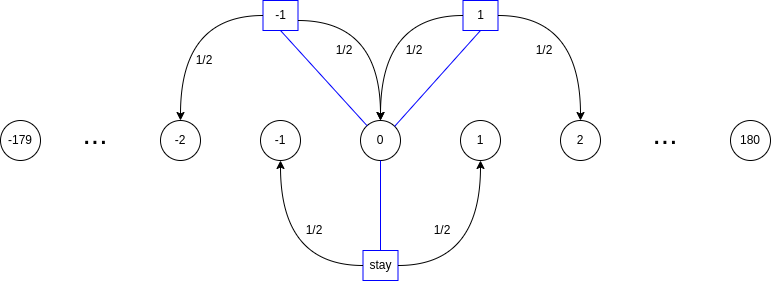

In [99]:
display.Image("./model_1.png")

The blue boxes represent actions; the black circles represent the states. For state 0, there are three actions; for example, if we take action stay, we have a 0.5 possibility of going to state -1 and a 0.5 possibility of going to state 1. If we take action -1, there is a 0.5 possibility of going to state -2 and a 0.5 possibility of going to state 0, the same as action -1. And for each state, we have the same transition model.

1.2 Compute the optimal solution for a given discount factor $\gamma$

We can use value iteration [Bellman, 1957]  to compute the optimal solution. Assume $V_{opt}$ is the optimal value

(1) Initialize $V_{opt}^{0}(s) \leftarrow 0$

(2) Loop:

(3) &emsp;&emsp; For each state $s$:

(4) &emsp;&emsp; $V_{opt}^{t}(s) \leftarrow \underset{a \in A(s)}{\operatorname{\max}} Reward(s, ac, s') + \underset{s'} \sum p(s'|s, ac)\gamma V_{opt}^{t-1}(s')$

(5) Until $V^t - V^{t-1} < \epsilon$.

The optimal policy is compute by the following formula:

$\pi(s) = \underset{ac}argmax Reward(s, ac, s') + \underset{s'} \sum p(s'|s, ac)\gamma V_{opt}^{t-1}(s')$

2. Implement an algorithm that finds the optimal solution and illustrate the optimal solution.

2.1 We implement the above algorithm in this part to find the optimal solution.

In [100]:
# epsilon is a threshold that determines the accuracy of estimation.
epsilon = 1e-6

In [101]:
# Transform the angle between [0, 359]; we want to guarantee the  angle in this interval because
# we want to use a list to save the value of each theta; in this case, theta is also the indices of the list.
def transform_angle(theta):
    if theta < 0:
        return theta + 360
    elif theta >= 360:
        return theta - 360
    else:
        return theta

In [102]:
# Compute the generated energy according to theta
def product_energy(theta):
    # Transform the theta so that theta in [0, 359]
    theta = transform_angle(theta)
    # compute the energy according to the formula. In this part, we could obtain negative energy, 
    # we will deal with the result in the following function.
    return np.cos(theta*np.pi/180)

In [103]:
# Input: i in [0, 359], v_opt is a 2*360 matrice, a is the cost energy of moving left or right, 
#        gamma is a given discount factor.

# Output: two lists, the first is computed with negative energy when theta is in (90, 270)
#         the second list is when energy is negative, we set it to zero, which means energy = max(0, energy)
#         We also save the first list because just setting negative energy to zero is not an accurate way to compute the turning orientation.
#         For each list, there a three values which represent there actions: -1, 0, 1.
def compute_q(i, v_opt, a, gamma):
    energy = np.array([product_energy(i-2), product_energy(i-1), product_energy(i), product_energy(i+1), product_energy(i+2)])
    energy_v = np.copy(energy)
    energy_v[energy_v < 0] = 0
    return np.array([-a+0.5*(energy[0]+gamma*v_opt[0, transform_angle(i-2)])+0.5*(energy[2]+gamma*v_opt[0, i]),\
                    0.5*(energy[1]+gamma*v_opt[0, transform_angle(i-1)])+0.5*(energy[3]+gamma*v_opt[0, transform_angle(i+1)]),\
                    -a+0.5*(energy[4]+gamma*v_opt[0, transform_angle(i+2)])+0.5*(energy[2]+gamma*v_opt[0, i])]),\
           np.array([-a+0.5*(energy_v[0]+gamma*v_opt[0, transform_angle(i-2)])+0.5*(energy_v[2]+gamma*v_opt[0, i]),\
                    0.5*(energy_v[1]+gamma*v_opt[0, transform_angle(i-1)])+0.5*(energy_v[3]+gamma*v_opt[0, transform_angle(i+1)]),\
                    -a+0.5*(energy_v[4]+gamma*v_opt[0, transform_angle(i+2)])+0.5*(energy_v[2]+gamma*v_opt[0, i])]) 

In [104]:
# Compute the optimal value and return the optimal policy
# Input : a is the cost energy of moving left or right, 
#         gamma is a given discount factor.
# Output : the optimal policy for each theta
def compute_optimal(a, gamma):
    # save the t-1 optimal value for each state in v_opt[0] and t optimal value for each state in v_opt[1]
    v_opt = np.zeros([2, 360])
    # Set the max iteration to avoid too much time in iteration
    k = 0  
    while True:
        # save the optimal policy in pi_opt
        pi_opt = np.zeros(360, dtype=int)
        for i in range(360):
            tmp_1, tmp_2 = compute_q(i, v_opt, a, gamma)
            # tmp_2 is the energy generated to avoid negative energy
            v_opt[1, i] = np.max(tmp_2)
            # tmp_1 is the list computed by negative energy; with this list, we can know exactly which action is better.
            # # use np.argmax(tmp_1) - 1 to convert the indice to action
            pi_opt[i] = np.argmax(tmp_1) - 1
        # check to break condition    
        if np.abs(np.linalg.norm(v_opt[0]-v_opt[1])) < epsilon or k > 100:
            break
        v_opt[0] = v_opt[1]
        k += 1
    return pi_opt

In [105]:
def optimal_policy(a, gamma):
    # comput the optimal policy
    policy = compute_optimal(a, gamma)
    x = [i for i in range(360)]
    figure = plt.figure(figsize=(8,4))

    plt.scatter(x, policy)
    plt.xlabel('theta')
    plt.ylabel('action')
    title = "a = "+str(a)+", "+"gamma = "+str(gamma)
    plt.title(title)
    plt.show()
                         

2.2 Analyse the results

If a = 0, that means there is no cost for turning the turbine. So the expected result is:

\begin{equation}
\label{eq6}
ac=\left\{
\begin{aligned}
-1& , & 0 <\theta \leq 180, \\
1 & , & 180 <\theta \leq 359, \\
0 & , & \theta = 0.
\end{aligned}
\right.
\end{equation}

We can check the result with a = 0, gamma = 0.

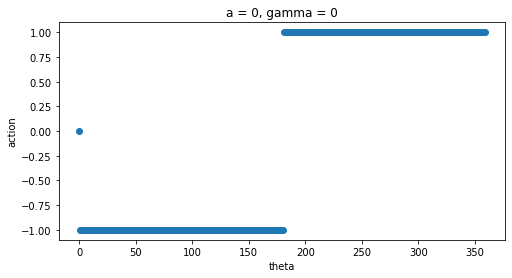

In [106]:
# a = 0, gamma = 0
optimal_policy(0, 0)

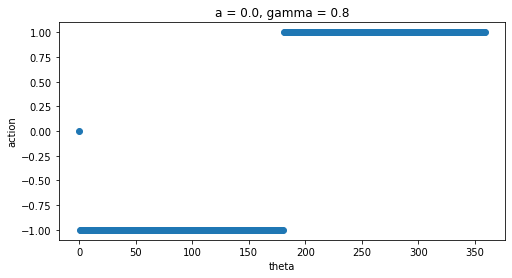

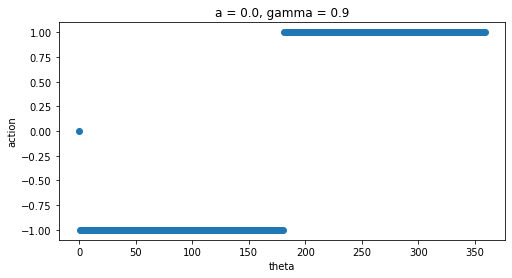

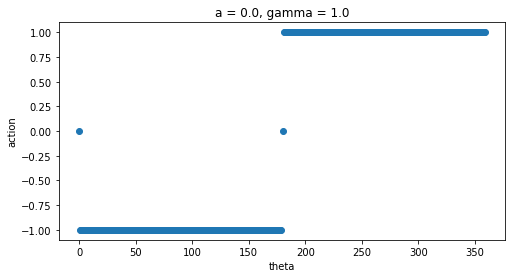

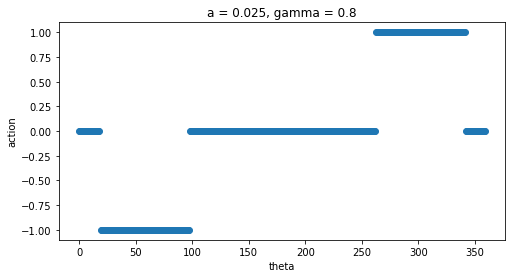

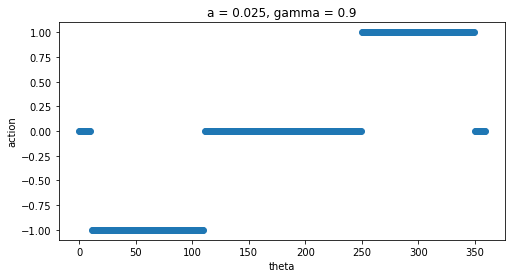

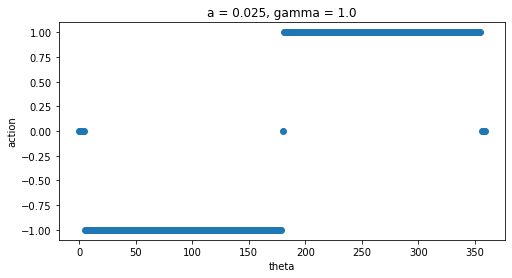

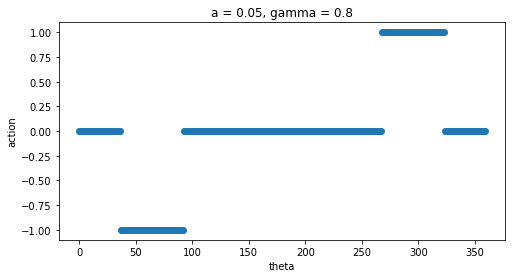

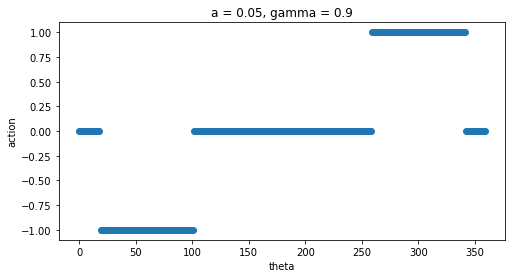

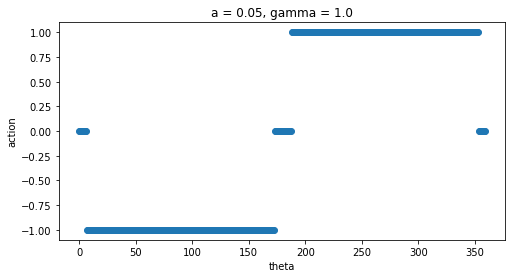

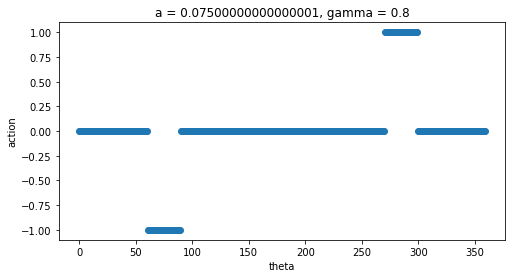

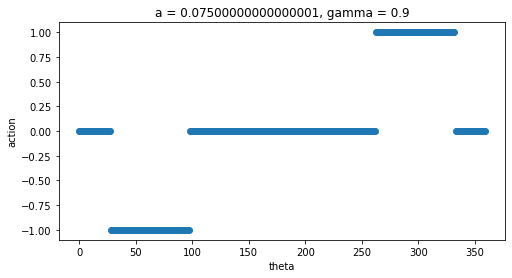

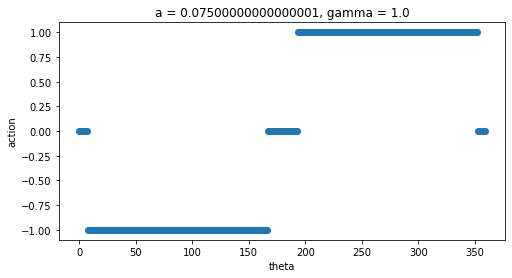

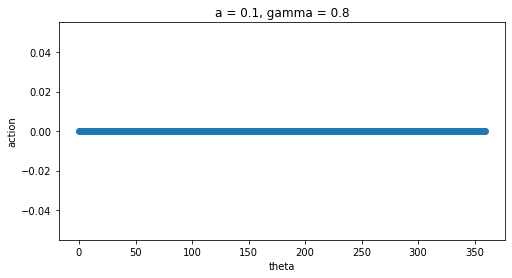

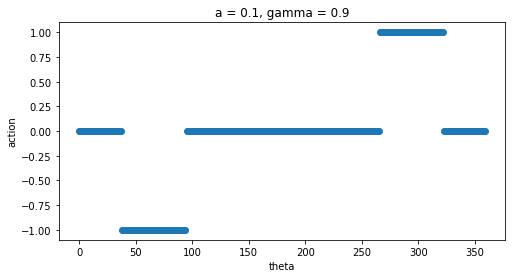

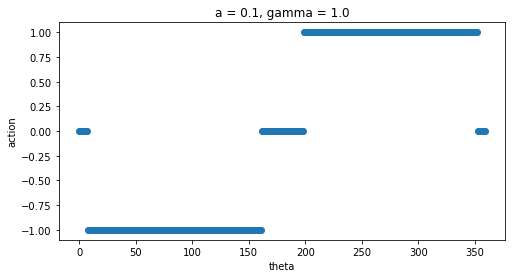

In [107]:
# Set a = [0, 0.025, 0.05, 0.075, 0.1], gamma = [0.8, 0.9, 1.0] and choose the combination of a and gamma then print the result

a = np.linspace(0, 0.1, 5)
gamma = np.linspace(0.8, 1, 3)
for a_i in a:
    for gamma_j in gamma:
        optimal_policy(a_i, gamma_j)

(1) We notice that if $a = 0$, no matter what value gamma takes, the turbine will move towards $theta = 0$ to get the most significant energy.

(2) As the value of $a$ increases, the decision is the tradeoff between the cost energy $a$ and the generated energy.

(3) In one of the above figure with $a=0.1, gamma = 0.8$, all the decision is $ac = 0$, which means the turbine prefer not to move because the cost energy is greater than the generated energy.

3. Assume now that the wind at time $t + 1$ evolves as $V (t + 1) = max(0, min(1.1, V (t) + b∆(t)))$

3.1 Model the problem as a MDP

We know that $V_{max} = 1$, so $V \in [0, 1]$. We set the interval equal to 0.02, so we can cut V to 50 points, that means $v \in \{0.02, 0.04, 0.06, ..., 1.0\}$.

States : $\theta_i$ represents the difference between the turbine's orientation and the wind's orientation, $i \in \{0, 1, 2,...,359\}$. $v_j$ represents the wind, $j \in \{0, 1,2, ..., 49\}$. A state is the combination of $\theta$ and $v$; we know the number of $\theta$ is 360 and the number of $v$ is 100, so the total state is 36,000. A state $s = (\theta_i, v_j)$.

Actions $A$: the control the angle of the turbine, we have three actions in a given state: one degree left, stay still, or one degree right.

$A = \{-1, 0, 1\}$, for an action $ac$, $ac\in A$.

$ ac = -1$ : one degree left; </br> $ ac = 0 $ : stay still; </br> $ ac = 1$ : one degree right. 

$Reward(s, ac, s')$ : reward for the transition $(s, ac, s')$. $a$ is the cost of energy for moving left or right, in this case :

\begin{equation}
\label{eq6}
Reward(s, ac, s')=\left\{
\begin{aligned}
f(V)cos(\theta)& , & ac = 0, \\
f(V)cos(\theta) - a & , & otherwise.
\end{aligned}
\right.
\end{equation}
We can compute $f(V)$ according to $v_{t-1}$, the following part is the method to compute $f(v)$.

In [108]:
# Set interval equals to 0.01 so we have 100v
interval = 0.02
b = 0.5
v = np.arange(0+interval, 1+interval, interval)
N = len(v)
print(v, "\n", "The size of v is :", N)

[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56
 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ] 
 The size of v is : 50


We know that $v(t+1) = max(0, min(1.1, v(t) + b∆(t)))$, the lower bound of $v(t+1)$ is $v_t-b$ and the upper bound of $v(t+1)$ is $v_t+b$ and this is uniform distribution, and $v(t+1)$ is also bounded by 0, and 1. Hence:


$max(0, v_t -b) \leqslant v(t+1) \leqslant min(1, v_t + b)$

In [109]:
# Compute f_v accordint v
# Output f_v with length of 100
def compute_fv(interval, b):
    result = []
    for v_t in v:
        lower = v_t - b
        upper = v_t + b
        # Prob for each v
        prob = interval/(upper - lower)
        lower_t, upper_t = lower, upper
        if lower_t < 0:
            lower_t = 0
        if upper_t > 1:
            upper_t = 1
        # the probability of v in list is prob computed on the above line, 
        # the probability of v not in list is 0
        list = np.arange(lower_t+interval, upper_t+interval, interval)
        sum_f = sum(np.power(list, 3))
        result.append(sum_f*prob)
    return result

In [110]:
f_v = compute_fv(interval, b)

In [111]:
# Compute the generated energy according to theta, j, f_v
def product_energy(theta, j, f_v):
    # Transform the theta so that theta in [0, 359]
    theta = transform_angle(theta)
    # compute the energy according to the formula. In this part, we could obtain negative energy, 
    # we will deal with the result in the following function.
    return np.cos(theta*np.pi/180)*f_v[j]

In [112]:
# Input: i in [0, 359], v_opt is a 2*360 matrice, a is the cost energy of moving left or right, 
#        gamma is a given discount factor.

# Output: two lists, the first is computed with negative energy when theta is in (90, 270)
#         the second list is when energy is negative, we set it to zero, which means energy = max(0, energy)
#         We also save the first list because just setting negative energy to zero is not an accurate way to compute the turning orientation.
#         For each list, there a three values which represent there actions: -1, 0, 1.
def compute_q(i, j, v_opt, a, gamma, f_v):
    energy = np.array([product_energy(i-2, j, f_v), product_energy(i-1, j, f_v), product_energy(i, j, f_v), product_energy(i+1, j, f_v), product_energy(i+2, j, f_v)])
    energy_v = np.copy(energy)
    energy_v[energy_v < 0] = 0
    return np.array([-a+0.5*(energy[0]+gamma*v_opt[0, j, transform_angle(i-2)])+0.5*(energy[2]+gamma*v_opt[0, j, i]),\
                    0.5*(energy[1]+gamma*v_opt[0, j, transform_angle(i-1)])+0.5*(energy[3]+gamma*v_opt[0, j, transform_angle(i+1)]),\
                    -a+0.5*(energy[4]+gamma*v_opt[0, j, transform_angle(i+2)])+0.5*(energy[2]+gamma*v_opt[0, j, i])]),\
           np.array([-a+0.5*(energy_v[0]+gamma*v_opt[0, j, transform_angle(i-2)])+0.5*(energy_v[2]+gamma*v_opt[0, j, i]),\
                    0.5*(energy_v[1]+gamma*v_opt[0, j, transform_angle(i-1)])+0.5*(energy_v[3]+gamma*v_opt[0, j, transform_angle(i+1)]),\
                    -a+0.5*(energy_v[4]+gamma*v_opt[0, j, transform_angle(i+2)])+0.5*(energy_v[2]+gamma*v_opt[0, j, i])]) 

In [113]:
# Compute the optimal value and return the optimal policy
# Input : a is the cost energy of moving left or right, 
#         gamma is a given discount factor.
# Output : the optimal policy for each theta
def compute_optimal_w(a, gamma, N, f_v):
    # save the t-1 optimal value for each state in v_opt[0] and t optimal value for each state in v_opt[1]
    v_opt = np.zeros([2, N, 360])
    # Set the max iteration to avoid too much time in iteration
    k = 0  
    while True:
        # save the optimal policy in pi_opt
        pi_opt = np.zeros([N, 360], dtype=int)
        for i in range(360):
            for j in range(N):
                tmp_1, tmp_2 = compute_q(i, j, v_opt, a, gamma, f_v)
                # tmp_2 is the energy generated to avoid negative energy
                v_opt[1, j, i] = np.max(tmp_2)
                # tmp_1 is the list computed by negative energy; with this list, we can know exactly which action is better.
                # # use np.argmax(tmp_1) - 1 to convert the indice to action
                pi_opt[j, i] = np.argmax(tmp_1) - 1
        # check to break condition    
        if np.abs(np.linalg.norm(v_opt[0]-v_opt[1])) < epsilon or k > 100:
            break
        v_opt[0] = v_opt[1]
        k += 1
    return pi_opt

In [114]:
def draw_optimal(a, gamma, optimal_policy):
    X=[i for i in range(360)]
    Z = optimal_policy 
    Y = v
    X,Y = np.meshgrid(X,Y)
    fig = plt.figure()
    colors = ['r','g','b']
    ax = plt.axes(projection='3d') 
    ax.scatter(X,Y,Z, alpha=0.1 ,c='r',marker='o',s=0.5)
    ax.set_xlabel('theta')
    ax.set_ylabel('v')
    ax.set_zlabel('action')
    title = "a = "+str(a)+", "+"gamma = "+str(gamma)
    ax.set_title(title)
    plt.show()

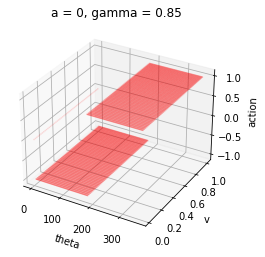

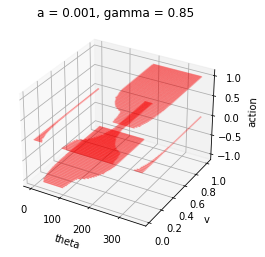

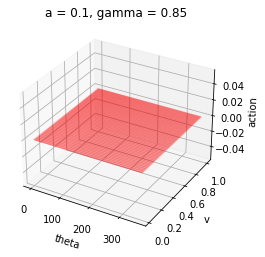

In [116]:
a = [0, 0.001, 0.1]
gamma = 0.85
for a_i in a:
    optimal_policy = compute_optimal_w(a_i, gamma, N, f_v)
    draw_optimal(a_i, gamma, optimal_policy)

We notice that the optimal policy is to stay still with the value of $a$ increase to a certain value. More precisely, when $a$ equals 0, the optimal policy is $-1$, or $1$.

4. In addition to the above, assume that the wind has some momentum: with 90% changes, the change in the orientation of the wind turbine will be the same as the one last time.

4.1 Model the problem as a MDP

States : we use $k = 0$ represents the wind turn -1 and $k = 1$ represents the wind turn +1, so in addition to the states in question 3, we add $k$ to the state, hence in this case, a state $s = (\theta_i, v_j, k)$, $k \in \{0, 1 \}$. So the total number of states is 72,000. So states is a three dimensions matrix.

The actions and rewards is the same as question 3.

If $k = 0$, that means this time the wind turns -1, so in the next step, the probability of turning left is 0.9, and the probability of turning right is 0.1. We show the transition graph as below:

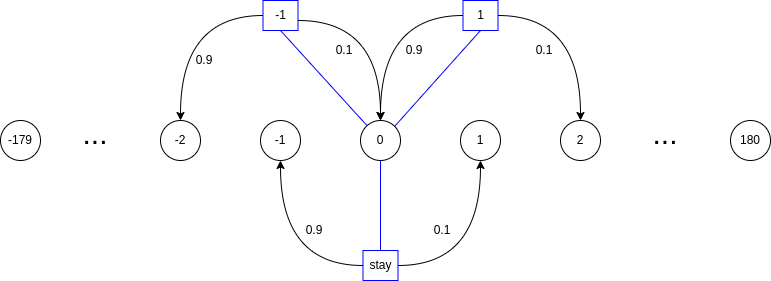

In [117]:
display.Image("./model_4_1.png")

If $k = 1$, it's the opposite situation; we show the transition graph below:

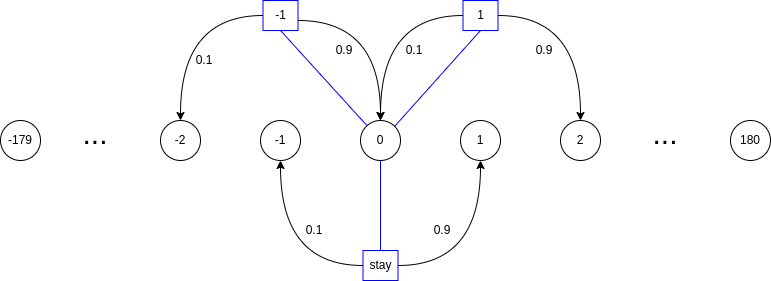

In [118]:
display.Image("./model_4_2.png")

The following step is to find the optimal policy.

In [119]:
def compute_q(i, j, k, v_opt, a, gamma, f_v):
    # Set p according to the value of k
    p = 0.9 if k==0 else 0.1    
    energy = np.array([product_energy(i-2, j, f_v), product_energy(i-1, j, f_v), product_energy(i, j, f_v), product_energy(i+1, j, f_v), product_energy(i+2, j, f_v)])
    energy_v = np.copy(energy)
    energy_v[energy_v < 0] = 0
    return np.array([-a+p*(energy[0]+gamma*v_opt[0, k, j, transform_angle(i-2)])+(1-p)*(energy[2]+gamma*v_opt[0, k, j, i]),\
                    p*(energy[1]+gamma*v_opt[0, k, j, transform_angle(i-1)])+(1-p)*(energy[3]+gamma*v_opt[0, k, j, transform_angle(i+1)]),\
                    -a+(1-p)*(energy[4]+gamma*v_opt[0, k, j, transform_angle(i+2)])+p*(energy[2]+gamma*v_opt[0, k, j, i])]),\
           np.array([-a+p*(energy_v[0]+gamma*v_opt[0, k, j, transform_angle(i-2)])+(1-p)*(energy_v[2]+gamma*v_opt[0, k, j, i]),\
                    p*(energy_v[1]+gamma*v_opt[0, k, j, transform_angle(i-1)])+(1-p)*(energy_v[3]+gamma*v_opt[0, k, j, transform_angle(i+1)]),\
                    -a+(1-p)*(energy_v[4]+gamma*v_opt[0, k, j, transform_angle(i+2)])+p*(energy_v[2]+gamma*v_opt[0, k, j, i])]) 

In [120]:
def compute_optimal_c(a, gamma, N, f_v):
    # save the t-1 optimal value for each state in v_opt[0] and t optimal value for each state in v_opt[1]
    v_opt = np.zeros([2, 2, N, 360])
    # Set the max iteration to avoid too much time in iteration
    s = 0  
    while True:
        # save the optimal policy in pi_opt
        pi_opt = np.zeros([2, N, 360], dtype=int)
        for i in range(360):
            for j in range(N):
                    for k in range(2):
                        tmp_1, tmp_2 = compute_q(i, j, k, v_opt, a, gamma, f_v)
                        # tmp_2 is the energy generated to avoid negative energy
                        v_opt[1, k, j, i] = np.max(tmp_2)
                        # tmp_1 is the list computed by negative energy; with this list, we can know exactly which action is better.
                        # # use np.argmax(tmp_1) - 1 to convert the indice to action
                        pi_opt[k, j, i] = np.argmax(tmp_1) - 1
        # check to break condition    
        if np.abs(np.linalg.norm(v_opt[0]-v_opt[1])) < epsilon or s > 100:
            break
        v_opt[0] = v_opt[1]
        s += 1
    return pi_opt

k = 0


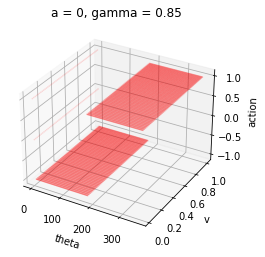

k = 1


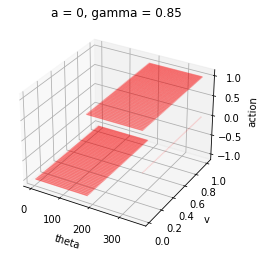

k = 0


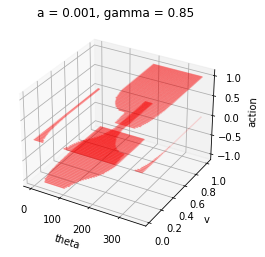

k = 1


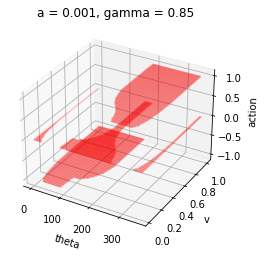

k = 0


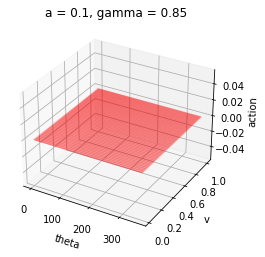

k = 1


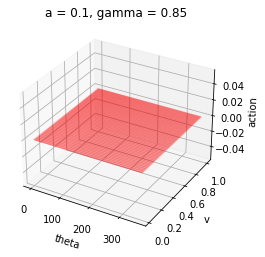

In [147]:
a = [0, 0.001, 0.1]
gamma = 0.85
for a_i in a:
    optimal_policy = compute_optimal_c(a_i, gamma, N, f_v)
    print("k = 0")
    draw_optimal(a_i, gamma, optimal_policy[0])
    print("k = 1")
    draw_optimal(a_i, gamma, optimal_policy[1])

k = 0


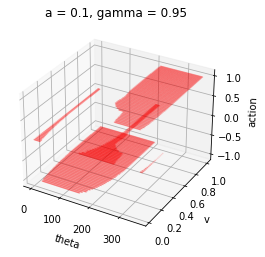

k = 1


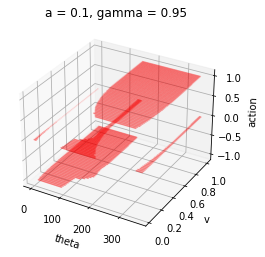

In [149]:
a = 0.001
gamma = 0.95
optimal_policy = compute_optimal_c(a, gamma, N, f_v)
print("k = 0")
draw_optimal(a_i, gamma, optimal_policy[0])
print("k = 1")
draw_optimal(a_i, gamma, optimal_policy[1])

We analyze our results from three perspectives. Firstly, the value of turning consumption ranges from small to large, and the strategy of the windmill changes from positive to negative. The second point, analyzed in terms of wind speed, is that the higher the wind speed, the more positive the turbine strategy; conversely, the windmill tends not to move. In the third point, from the analysis of the inertia of the wind, we have calculated two diagrams, which represent the actions taken by the wind under two opposite inertias, which are mirror images of each other. Unlike the third question, we can see that each graph is not symmetrical at 180 degrees due to the inertia of the wind. This asymmetry is even more pronounced when the $\gamma$ becomes larger because we give more weight to future forecasts in the expectation of long-term gains. So this leads to the inertia of the wind having a more significant impact on the output. These points are consistent with common sense and thus show that our trained model is valid. 